In [3]:
%load_ext autoreload
%autoreload 2
from confignb import *

X, y, pts, ks, masks = util.load_data('data/processed/ASCADv.h5')
splits_precomputed_poly = pickle.load(open("data/processed/splits_poly.pkl", "rb"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
models = [
    ('RF (depth=15)', simplerf(SEED, depth=15)),
    ('RF (depth=10)', simplerf(SEED, depth=10)),
    ('LR', make_pipeline(
        StandardScaler(),
        LogisticRegression(C=0.01, tol=1e-3, random_state=SEED, verbose=1)
    ))
]
df_models_poly = []

for (name, model) in models:
    results = cv_precomputed(model, splits_precomputed_poly, verbose=False)
    logging.info(f"[{name}]: {results['atk_score_mean'].mean():.4f}")

    df_models_poly.append(util.results_to_dict(results, model=name))
    util.save_results(df_models_poly, "models_poly_fscore")

04:15:25: [RF (depth=15)]: 0.0888
04:23:18: [RF (depth=10)]: 0.0884
04:25:02: [LR]: 0.1029


(<Figure size 700x500 with 2 Axes>,
 <Axes: title={'center': 'Poly Features + ANOVA F-score\nBest: 0.1029 (±0.0158) '}, ylabel='Perceived Information'>)

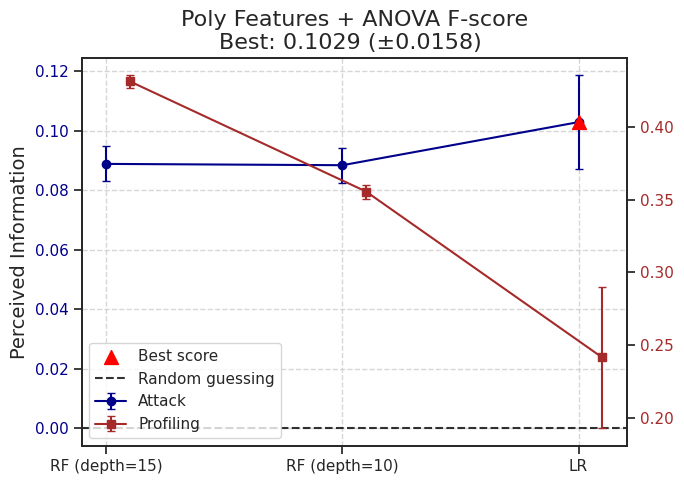

In [4]:
plots.plot_gs_results(
    'models_poly_fscore', key='model', loc='lower left',
    title='Poly Features + ANOVA F-score', xlab=''
)

In [5]:
rf_pl = make_pipeline(
    SelectFromModel(simplerf(SEED), max_features=100),
    StandardScaler(),
    PolynomialFeatures(degree=(2, 2), interaction_only=True, include_bias=False),
    SelectKBest(f_classif, k=750),
    simplerf(SEED)
).fit(X, y)

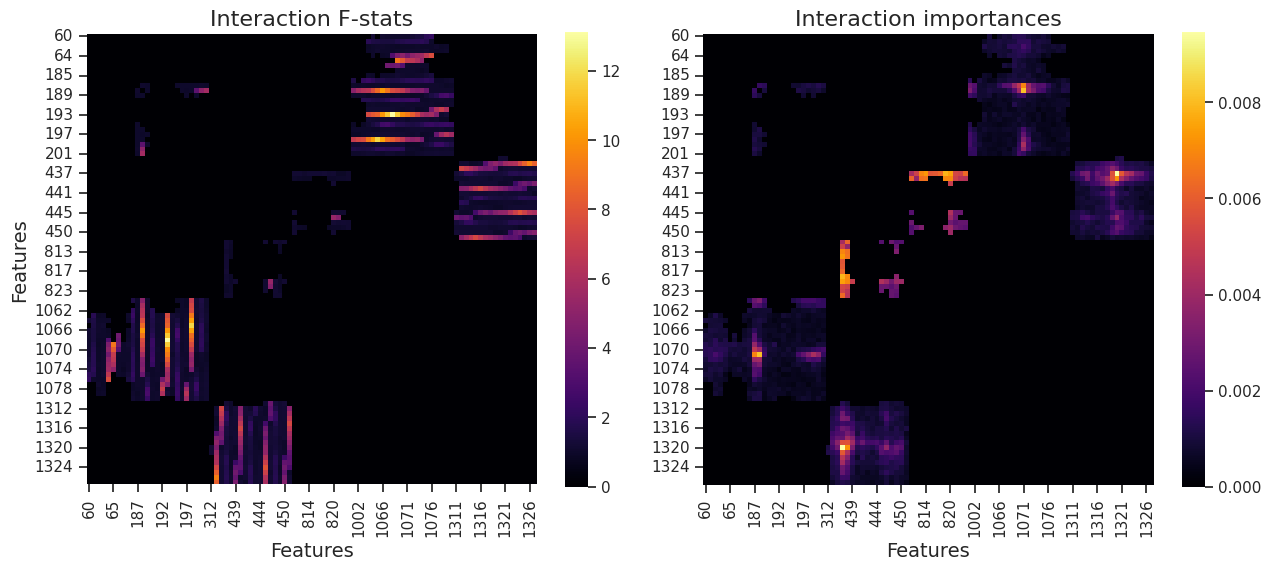

In [6]:
rf_info = util.inspect_pipeline(rf_pl)
feats = rf_info['selected_features']
fi = rf_pl.named_steps['randomforestclassifier'].feature_importances_

R = pd.DataFrame(np.zeros((len(feats), len(feats))), columns=feats, index=feats)
RFI = pd.DataFrame(np.zeros((len(feats), len(feats))), columns=feats, index=feats)

for (a, b), f, score in zip(rf_info['pairs'], fi, rf_info['scores']):
    R.loc[a, b] = R.loc[b, a] = score
    RFI.loc[a, b] = RFI.loc[b, a] = f

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

sns.heatmap(R, cmap='inferno', square=True, ax=ax1, cbar_kws={'shrink': 0.85})
plots.labs(ax1, xlab='Features', ylab='Features', title='Interaction F-stats')

sns.heatmap(RFI, cmap='inferno', square=True, ax=ax2, cbar_kws={'shrink': 0.85})
plots.labs(ax2, xlab='Features', ylab='', title='Interaction importances')

fig.tight_layout()
plots.savetight(fig, '07_interaction_fstats_vs_importances')

In [4]:
gs = []

for c in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]:
    pl = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=c, tol=1e-3, random_state=SEED, verbose=1)
    )
    results = cv_precomputed(pl, splits_precomputed_poly, verbose=False)
    gs.append(util.results_to_dict(results, C=c))

    logging.info(f"[{c}]: {results['atk_score_mean'].mean():.4f}")
    util.save_results(gs, "lr_poly")

10:14:49: [0.0001]: 0.0625
10:16:12: [0.0005]: 0.1060
10:17:38: [0.001]: 0.1153
10:19:22: [0.005]: 0.1098
10:21:05: [0.01]: 0.1029


(<Figure size 700x500 with 2 Axes>,
 <Axes: title={'center': 'Logistic Regression with Poly Features + ANOVA F-score\nBest: 0.1153 (±0.0128) '}, xlabel='POI', ylabel='Perceived Information'>)

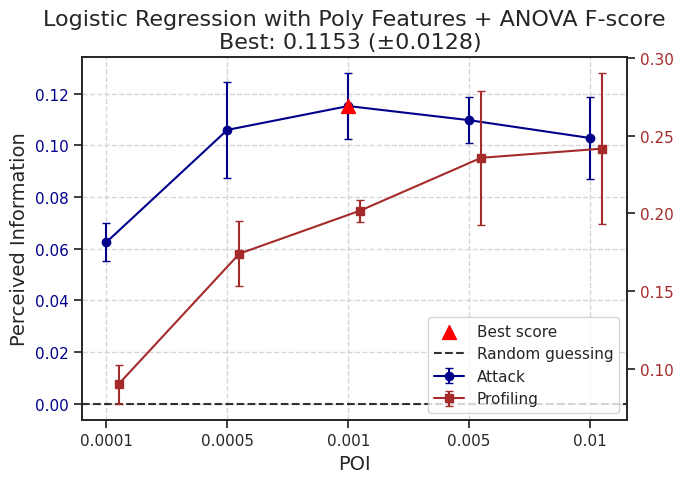

In [5]:
plots.plot_gs_results(
    'lr_poly', key='C', loc='lower right',
    title='Logistic Regression with Poly Features + ANOVA F-score'
)

In [6]:
gs = []

for n_clust in [100, 200, 300, 500, 750]:
    for coef in [5e-4, 1e-3, 5e-3, 1e-2]:
        pl = make_pipeline(
            util.ClusterFeatures(n_clusters=n_clust),
            StandardScaler(),
            LogisticRegression(C=coef, tol=1e-3, random_state=SEED, verbose=1)
        )
        results = cv_precomputed(pl, splits_precomputed_poly, verbose=False)
        gs.append(util.results_to_dict(results, C=coef, n_clusters=n_clust))

        logging.info(f"[{n_clust}], [{coef:.4f}]: {results['atk_score_mean'].mean():.4f}")
        util.save_results(gs, "lr_clustered_poly")

10:21:06: Clustering features...
10:21:06: Clustering complete (took 0.52 seconds), created 100 clusters.
10:21:08: Clustering features...
10:21:09: Clustering complete (took 0.49 seconds), created 100 clusters.
10:21:11: Clustering features...
10:21:11: Clustering complete (took 0.52 seconds), created 100 clusters.
10:21:14: Clustering features...
10:21:14: Clustering complete (took 0.46 seconds), created 100 clusters.
10:21:16: Clustering features...
10:21:17: Clustering complete (took 0.48 seconds), created 100 clusters.
10:21:19: Clustering features...
10:21:19: Clustering complete (took 0.45 seconds), created 100 clusters.
10:21:22: Clustering features...
10:21:22: Clustering complete (took 0.46 seconds), created 100 clusters.
10:21:24: Clustering features...
10:21:25: Clustering complete (took 0.46 seconds), created 100 clusters.
10:21:28: Clustering features...
10:21:28: Clustering complete (took 0.51 seconds), created 100 clusters.
10:21:30: Clustering features...
10:21:31: Clu

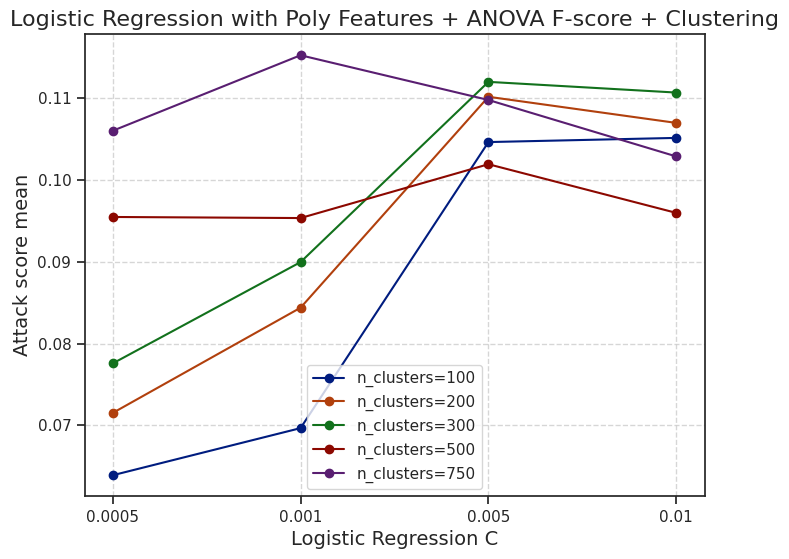

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
df = pd.read_csv('data/results/lr_clustered_poly.csv')
xaxis = np.arange(len(df['C'].unique()))

for i,nc in enumerate(df['n_clusters'].unique()):
    df_c = df[df['n_clusters'] == nc]
    ax.plot(xaxis, df_c['atk_score_mean'], label=f'n_clusters={nc}', marker='o')

ax.set_xticks(xaxis)
ax.set_xticklabels(list(df['C'].unique()))
ax.legend(loc='lower center')
ax.grid(True, linestyle='--', alpha=0.8)
plots.labs(ax, xlab='Logistic Regression C', ylab='Attack score mean',
           title='Logistic Regression with Poly Features + ANOVA F-score + Clustering')
plots.savetight(fig, 'lr_clustered_poly')

In [9]:
pl_lr = make_pipeline(
    SelectFromModel(simplerf(SEED), max_features=100),
    StandardScaler(),
    PolynomialFeatures(degree=(2, 2), interaction_only=True, include_bias=False),
    SelectKBest(f_classif, k=750),
    # util.ClusterFeatures(n_clusters=200),
    # StandardScaler(),
    LogisticRegression(C=1e-3, tol=1e-3, random_state=SEED, verbose=1)
).fit(X, y)

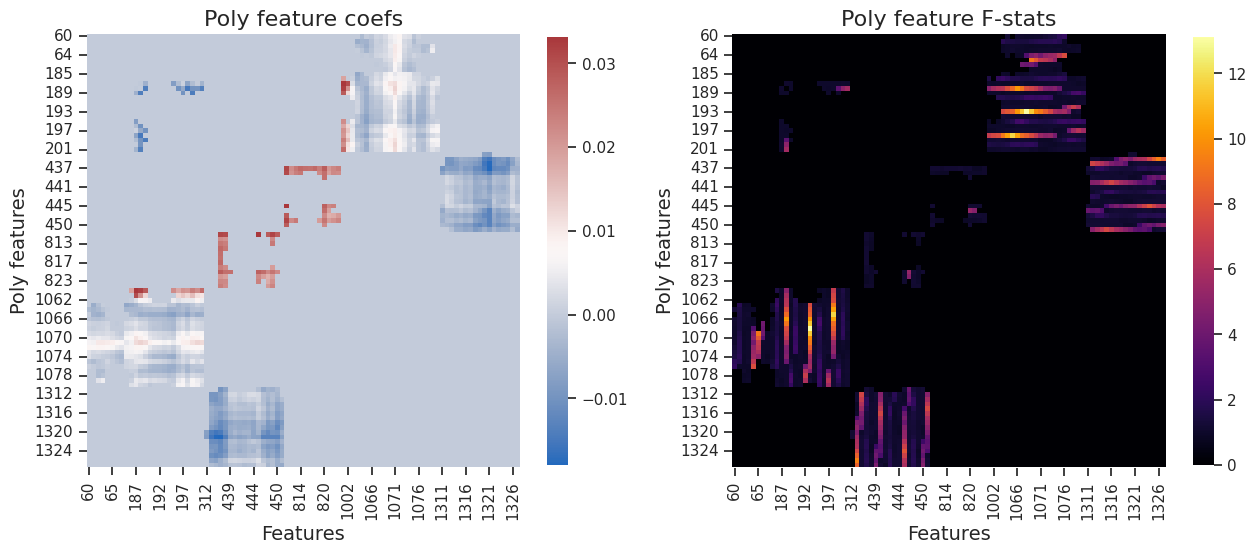

: 

In [ ]:
lr_info = util.inspect_pipeline(pl_lr)
feats = lr_info['selected_features']
coefs = pl_lr.named_steps['logisticregression'].coef_[0]

C = pd.DataFrame(np.zeros((len(feats), len(feats))), columns=feats, index=feats)
R = pd.DataFrame(np.zeros((len(feats), len(feats))), columns=feats, index=feats)

for (a, b), coef, score in zip(lr_info['pairs'], coefs, lr_info['scores']):
    C.loc[a, b] = C.loc[b, a] = coef
    R.loc[a, b] = R.loc[b, a] = score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
sns.heatmap(C, cmap='vlag', square=True, ax=ax1, cbar_kws={'shrink': 0.8})
plots.labs(ax1, xlab='Features', ylab='Poly features', title='Poly feature coefs')

sns.heatmap(R, cmap='inferno', square=True, ax=ax2, cbar_kws={'shrink': 0.8})
plots.labs(ax2, xlab='Features', ylab='Poly features', title='Poly feature F-stats')

fig.tight_layout()
plots.savetight(fig, '07_lr_coefs_vs_fstats')

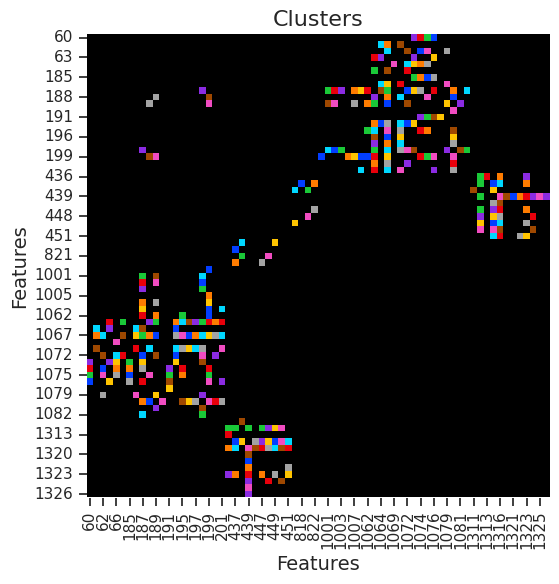

In [ ]:
clusterer = pl_lr.named_steps['clusterfeatures']

cluster_id = {}
color_idx = 1
for cluster in clusterer.cluster_indices_:
    if len(cluster) > 1:
        for idx in cluster:
            cluster_id[idx] = color_idx
        color_idx += 1

clus_repr = lr_info['cluster_repr']
clus_mat = np.zeros((len(feats), len(feats)), dtype=int)
for (a, b), rep_idx in zip(lr_info['pairs'], clus_repr):
    cid = cluster_id.get(rep_idx, 0)
    clus_mat[feats.index(a), feats.index(b)] = cid
    clus_mat[feats.index(b), feats.index(a)] = cid

CLUS = pd.DataFrame(clus_mat, columns=feats, index=feats)
n_clusters = color_idx
colors = [(0, 0, 0)] + sns.color_palette("bright", n_clusters-1)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    CLUS, cmap=colors, vmin=0, vmax=n_clusters-1, square=True, cbar=False, ax=ax
)
plots.labs(ax, xlab='Features', ylab='Features', title='Clusters')

fig.tight_layout()
plots.savetight(fig, '07_lr_poly_clusters')